In [1]:
import torch
from torch import nn, Tensor
import torch.optim as optim
import numpy as np
import PIL
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import (
    Dataset,
    DataLoader,
)

/home/jianant/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ganomaly_model

In [3]:
import utils

In [4]:
test_set = utils.MvtecDataset_test("bottle", "anomaly")
test_loader = DataLoader(dataset=test_set, batch_size=63, shuffle=False)

In [5]:
test_img = next(iter(test_loader))

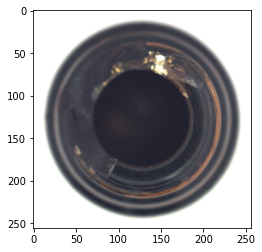

In [6]:
plt.imshow(np.rollaxis(test_img[0].numpy(), 0,3))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = ganomaly_model.Ganomaly([256,256], 100, 3, 64, 2, device)

In [9]:
model.load_state_dict(torch.load("01152023"))

<All keys matched successfully>

In [10]:
recon_img, latent_i, latent_o = model.generator(test_img.to(device))

In [11]:
recon_img = recon_img.detach().cpu()

In [12]:
recon_img.shape

torch.Size([63, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


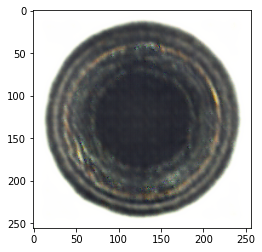

In [13]:
plt.imshow(np.rollaxis(recon_img.numpy()[0], 0,3))

In [15]:
latent_i = latent_i.detach().cpu().numpy()
latent_o = latent_o.detach().cpu().numpy()

In [16]:
anomaly_score_a = np.squeeze(np.mean(np.square(latent_i - latent_o), axis=1))

Text(0.5, 1.0, 'Anomaly score distribution for abnormal samples')

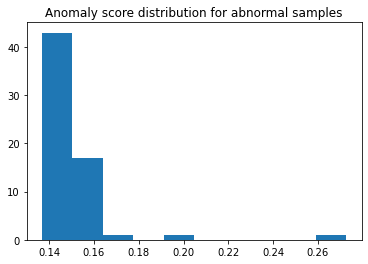

In [17]:
plt.hist(anomaly_score_a)
plt.title("Anomaly score distribution for abnormal samples")

In [18]:
torch.cuda.empty_cache()

In [19]:
test_set_2 =  utils.MvtecDataset_test("bottle", "good")
test_set_2.__len__()

20

In [20]:
test_loader_2 = DataLoader(dataset=test_set, batch_size=20, shuffle=False)

In [21]:
test_img_2 = next(iter(test_loader_2))

In [22]:
recon_img_2, latent_i_test_2, latent_o_test_2 = model.generator(test_img_2.to(device))

In [23]:
latent_i_n = latent_i_test_2.detach().cpu().numpy()
latent_o_n = latent_o_test_2.detach().cpu().numpy()

In [24]:
anomaly_score_n = np.squeeze(np.mean(np.square(latent_i_n - latent_o_n), axis=1))

Text(0.5, 1.0, 'Anomaly score distribution for normal samples')

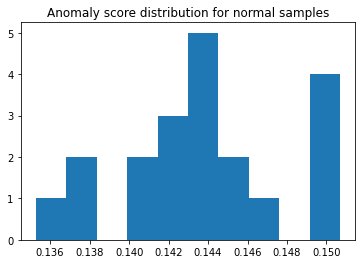

In [26]:
plt.hist(anomaly_score_n)
plt.title("Anomaly score distribution for normal samples")

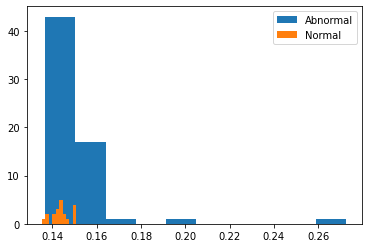

In [27]:
plt.hist(anomaly_score_a)
plt.hist(anomaly_score_n)
plt.legend(["Abnormal", "Normal"])

In [31]:
threshold = 0.140
accuracy = (np.sum(anomaly_score_a>threshold) + np.sum(anomaly_score_n<threshold))/(len(anomaly_score_a)+len(anomaly_score_n))
print(accuracy)

0.6987951807228916


In [34]:
threshold = 0.144
precision = np.sum(anomaly_score_a>threshold)/(np.sum(anomaly_score_a>threshold) + np.sum(anomaly_score_n>threshold))
recall = np.sum(anomaly_score_a>threshold)/len(anomaly_score_a)
print(f"precision: {precision}  recall: {recall}  threshold:{threshold}")
                                               

precision: 0.8301886792452831  recall: 0.6984126984126984  threshold:0.144


In [35]:
import sklearn

In [49]:
y_a = np.ones(anomaly_score_a.shape)
y_n = np.zeros(anomaly_score_n.shape)
y = np.concatenate((y_a, y_n))
print(y.shape)

(83,)


In [43]:
probs = np.concatenate((anomaly_score_a, anomaly_score_n))

In [47]:
from sklearn import metrics

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(y, probs)

Text(0.5, 1.0, 'Receiver Operating Characteristic Curve')

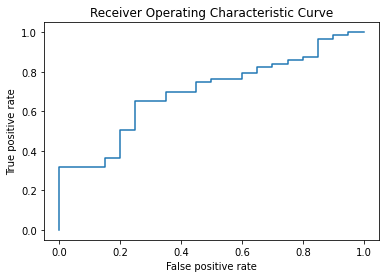

In [52]:
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver Operating Characteristic Curve")

In [53]:
auc = metrics.roc_auc_score(y, probs)
print(f"auc: {auc}")

auc: 0.6968253968253968
